A Company wants to automate the loan eligibility process based on customer details provided while filling online application form. 
The details filled by the customer are Gender, Marital Status, Education, Number of Dependents, Income of self and co applicant, Required Loan Amount, Required Loan Term, 

Credit History and others. The requirements are as follows:

1.)Check eligibility of the Customer given the inputs described above.(Classification)

2.)If customer is not eligible for the input required amount and duration:

a. what can be amount for the given duration.(Regression)

b. if duration is less than equal to 20 years, is customer eligible for required amount for some longer duration? What is that duration?(Regression)

# 1. To find out the Customer elligible for Loan

### Read data and Filter warnings

In [1]:
from warnings import filterwarnings
filterwarnings("ignore")

import pandas as pd
A = pd.read_csv("Desktop/DataSets/Project_Loan/Loan_training_set.csv")

### Preview of the dataset and checking features

In [2]:
A.head(3)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849.0,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,NaN,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000.0,0.0,66.0,360.0,1.0,Urban,Y


In [3]:
A.shape

(614, 13)

In [4]:
A.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             599 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          613 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    612 non-null    float64
 7   CoapplicantIncome  613 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(5), object(8)
memory usage: 62.5+ KB


In [5]:
A.columns

Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status'],
      dtype='object')

### Missing Data Treatment

In [6]:
A.isna().sum()

Loan_ID               0
Gender               15
Married               3
Dependents           15
Education             1
Self_Employed        32
ApplicantIncome       2
CoapplicantIncome     1
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [7]:
for i in A.columns:
    if A[i].dtypes == "object":
        x = A[i].mode()[0]
        A[i] = A[i].fillna(x)
    else:
        x = A[i].mean()
        A[i] = A[i].fillna(x)

In [8]:
A.isna().sum()

Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

### Define Y and Remove columns from A with less statistical importance

In [9]:
Y = A[["Loan_Status"]]
X = A.drop(labels=["Loan_ID","Loan_Status"],axis=1)

### EDA(Removing Skew/Outliers and finding important features for Model)

#### Removing Skew

In [10]:
X.skew()

ApplicantIncome      6.538870
CoapplicantIncome    7.492000
LoanAmount           2.726601
Loan_Amount_Term    -2.389680
Credit_History      -1.963600
dtype: float64

In [11]:
P = X.skew()
cols_with_skew = list(P[(P>1)].index)
cols_with_skew

['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']

In [12]:
import numpy as np

for j in cols_with_skew:
    
    W = []
    for i in X[j]:
        if (i != 0):
            W.append(np.log(i))
        else:
            W.append(i)
        
    X[j] = W

In [13]:
X.skew()

ApplicantIncome      0.477562
CoapplicantIncome   -0.172920
LoanAmount          -0.223227
Loan_Amount_Term    -2.389680
Credit_History      -1.963600
dtype: float64

#### Divide data in con and cat and finding important features

In [14]:
cat = []
con = []

for i in X.columns:
    if X[i].dtypes == "object":
        cat.append(i)
    else:
        con.append(i)
cat, con

(['Gender',
  'Married',
  'Dependents',
  'Education',
  'Self_Employed',
  'Property_Area'],
 ['ApplicantIncome',
  'CoapplicantIncome',
  'LoanAmount',
  'Loan_Amount_Term',
  'Credit_History'])

Ycat,Xcon --> ANOVA

Ycat,Xcat --> chisquare

In [15]:
imp_cat = []
imp_con = []


#Dependancy between a Categorical and Continueous feature can be defined using ANOVA Analysis

def chisq(df,cat1,cat2):
    import pandas as pd
    from scipy.stats import chi2_contingency
    ct = pd.crosstab(df[cat1],df[cat2])
    a,b,c,d = chi2_contingency(ct)
    return b

for i in cat:
    print("--------------------")
    print("Loan_Status vs",i)
    w = chisq(A,"Loan_Status",i)
    print(w)
    if(w < 0.05):
        imp_cat.append(i)
        
print('''====================================================
====================================================''')

#Dependancy between a Categorical and Categorical feature can be defined using Chisq test


def ANOVA(df,cat,con):
    from statsmodels.formula.api import ols
    relation = con + " ~ " + cat
    model = ols(relation,df).fit()
    from statsmodels.stats.anova import anova_lm
    anova_results = anova_lm(model)
    return round(anova_results.iloc[0,4],4)

for i in con:
    print("--------------------")
    print("Loan_Status vs",i)
    w = ANOVA(A,"Loan_Status",i)
    print(w)
    if(w < 0.05):
        imp_con.append(i)
    
                                            

--------------------
Loan_Status vs Gender
0.7391461310869638
--------------------
Loan_Status vs Married
0.029608580862582116
--------------------
Loan_Status vs Dependents
0.3688663081366005
--------------------
Loan_Status vs Education
0.04309962129357355
--------------------
Loan_Status vs Self_Employed
1.0
--------------------
Loan_Status vs Property_Area
0.0021360187811644915
--------------------
Loan_Status vs ApplicantIncome
0.9025
--------------------
Loan_Status vs CoapplicantIncome
0.1424
--------------------
Loan_Status vs LoanAmount
0.3677
--------------------
Loan_Status vs Loan_Amount_Term
0.604
--------------------
Loan_Status vs Credit_History
0.0


In [16]:
imp_cat

['Married', 'Education', 'Property_Area']

In [17]:
imp_con

['Credit_History']

### Preprocessing(Standardize Continueous cols and OneHotEncoding on Categorical cols)

In [18]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
X1 = pd.DataFrame(ss.fit_transform(X[imp_con]),columns=imp_con)

In [19]:
X2 = pd.get_dummies(X[imp_cat])

In [20]:
Xnew = X1.join(X2)
Xnew.head()

,Credit_History,Married_No,Married_Yes,Education_Graduate,Education_Not Graduate,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban
0,0.45164,1,0,1,0,0,0,1
1,0.45164,0,1,1,0,1,0,0
2,0.45164,0,1,1,0,0,0,1
3,0.45164,0,1,0,1,0,0,1
4,0.45164,1,0,1,0,0,0,1


In [21]:
Xnew.shape

(614, 8)

### Splitting Data into Training and Testing test to prepare Model

In [22]:
from sklearn.model_selection import train_test_split
xtrain,xtest,ytrain,ytest=train_test_split(Xnew,Y,test_size=0.2,random_state=21)

from sklearn.ensemble import RandomForestClassifier
dtc = RandomForestClassifier(criterion="entropy",random_state=21,max_depth=3)
model = dtc.fit(xtrain,ytrain)
pred_tr = model.predict(xtrain)
pred_ts = model.predict(xtest)
from sklearn.metrics import accuracy_score
tr_acc = accuracy_score(ytrain,pred_tr)
ts_acc = accuracy_score(ytest,pred_ts)
print("Training Accuracy is ",tr_acc)
print("Testing Accuracy is ",ts_acc)

Training Accuracy is  0.8065173116089613
Testing Accuracy is  0.8211382113821138


### Finding best value for Hyperparameters

In [23]:
tuning_grid = {"max_depth":range(2,5,1),"criterion":["gini","entropy"],"n_estimators":range(20,30,1)}

In [24]:
from sklearn.model_selection import GridSearchCV
rfc = RandomForestClassifier(random_state=21)
cv = GridSearchCV(rfc,tuning_grid,scoring="accuracy",cv=4)

cvmodel = cv.fit(xtrain,ytrain)

In [25]:
cvmodel.best_params_

{'criterion': 'gini', 'max_depth': 4, 'n_estimators': 20}

In [26]:
rfc = RandomForestClassifier(criterion='gini', max_depth=4, n_estimators= 20,random_state=21)
model = rfc.fit(xtrain,ytrain)
pred_tr = model.predict(xtrain)
pred_ts = model.predict(xtest)
from sklearn.metrics import accuracy_score
tr_acc = accuracy_score(ytrain,pred_tr)
ts_acc = accuracy_score(ytest,pred_ts)
print("Training Accuracy is ",tr_acc)
print("Testing Accuracy is ",ts_acc)

Training Accuracy is  0.8085539714867617
Testing Accuracy is  0.8048780487804879


# Getting Data ready for predictions

In [27]:
B = pd.read_csv("Desktop/DataSets/Project_Loan/Loan_testing_set.csv")

In [28]:
B1 = B[X.columns].head()

### Missing Data Treatment and Preprocessing

In [29]:
B.isna().sum()

Loan_ID               0
Gender               11
Married               0
Dependents           10
Education             0
Self_Employed        23
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount            5
Loan_Amount_Term      6
Credit_History       29
Property_Area         0
dtype: int64

In [30]:
for i in B.columns:
    if B[i].dtypes == "object":
        x = B[i].mode()[0]
        B[i] = B[i].fillna(x)
    else:
        x = B[i].mean()
        B[i] = B[i].fillna(x)

In [31]:
B.isna().sum()

Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
dtype: int64

In [32]:
cat = []
con = []
for i in B.columns:
    if(B[i].dtypes == "object"):
        cat.append(i)
    else:
        con.append(i)
        
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
B1 = pd.DataFrame(ss.fit_transform(B[con]),columns=con)

B2 = pd.get_dummies(B[cat])
Bnew = B1.join(B2)

In [33]:
ready_for_pred = Bnew[Xnew.columns]

In [34]:
predicted_final = model.predict(ready_for_pred)

In [35]:
E = pd.DataFrame([B.Loan_ID,predicted_final]).T
E.columns = ["Loan_ID","Loan_Status"]

In [36]:
E.to_csv("submission.csv")

In [37]:
E

,Loan_ID,Loan_Status
0,LP001015,Y
1,LP001022,Y
2,LP001031,Y
3,LP001035,Y
4,LP001051,N
...,...,...
362,LP002971,Y
363,LP002975,Y
364,LP002980,Y
365,LP002986,Y


# 2. If customer is not eligible for the input required amount and duration:
    
    a. what can be amount for the given duration.(Regression)

In [38]:
B["Loan_Status"] = predicted_final

In [39]:
B.columns

Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status'],
      dtype='object')

#### Find out people for whom loan was rejected(testing set)

In [40]:
Xtest = B[B.Loan_Status == "N"]
Xtest.head(2)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
4,LP001051,Male,No,0,Not Graduate,No,3276,0,78.0,360.0,1.0,Urban,N
7,LP001056,Male,Yes,2,Not Graduate,No,3881,0,147.0,360.0,0.0,Rural,N


In [44]:
Xtest_1 = Xtest.drop(labels=['Loan_ID','LoanAmount','Loan_Status'],axis=1)

In [45]:
Xtest_1.index = range(Xtest_1.shape[0])

#### Create training data based on above predictors

In [46]:
Q = A[Xtest_1.columns]
Q['LS'] = A.Loan_Status

In [47]:
Q = Q[Q.LS == "Y"]
Q = Q.drop(labels=["LS"],axis=1)

In [48]:
R = A[["LoanAmount"]]
R = R.iloc[Q.index,:]
R.index = range(0,R.shape[0])

In [49]:
Q.shape[0]

422

In [50]:
Q.index = range(0,Q.shape[0])

#### Preprocessing

In [51]:
def replacer(df):
    import pandas as pd
    Q = pd.DataFrame(df.isna().sum(),columns=["ct"])
    for i in Q[Q.ct > 0].index:
        if(df[i].dtypes == "object"):
            x = df[i].mode()[0]
            df[i] = df[i].fillna(x)
        else:
            x = df[i].mean()
            df[i] = df[i].fillna(x)

def preprocessing(df):
    import pandas as pd
    cat = []
    con = []
    for i in df.columns:
        if(df[i].dtypes == "object"):
            cat.append(i)
        else:
            con.append(i)
    X1 = pd.get_dummies(df[cat])
    from sklearn.preprocessing import StandardScaler
    ss = StandardScaler()
    X2 = pd.DataFrame(ss.fit_transform(df[con]),columns=con)
    X3 = X2.join(X1)
    return X3

In [54]:
replacer(Q)
replacer(Xtest_1)

In [55]:
xtrain = preprocessing(Q)
xtest_final = preprocessing(Xtest_1)

In [56]:
ytrain = R.LoanAmount

In [58]:
ytrain.head()

0    146.412162
1     66.000000
2    120.000000
3    141.000000
4    267.000000
Name: LoanAmount, dtype: float64

In [60]:
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
model = lm.fit(xtrain,ytrain)
pred = model.predict(xtest_final)

In [61]:
pred.shape

(65,)

In [62]:
act = B[B.Loan_Status == "N"][["LoanAmount"]]

In [64]:
act.index = range(0,65)

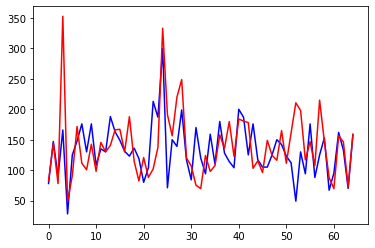

In [65]:
import matplotlib.pyplot as plt
plt.plot(act,c="blue")
plt.plot(pred,c="red")

# 2.b 

if duration is less than equal to 20 years, is customer eligible for required amount for some longer duration? What is that duration?(Regression)

In [66]:
B['Duration']=B.Loan_Amount_Term/12

In [67]:
data_for_pred = B[(B.Duration<=20)&(B.Loan_Status=="Y")]
data_for_pred_final = data_for_pred.drop(labels=['Duration','Loan_ID','Loan_Status',"Loan_Amount_Term"],axis=1)
data_for_pred_final.index = range(0,data_for_pred_final.shape[0])

In [68]:
data_for_pred_final.head(2)

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Credit_History,Property_Area
0,Male,Yes,2,Graduate,No,13633,0,280.0,1.000000,Urban
1,Male,No,3+,Graduate,No,4166,0,40.0,0.825444,Urban


In [69]:
data_for_pred_final.head(2)

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Credit_History,Property_Area
0,Male,Yes,2,Graduate,No,13633,0,280.0,1.000000,Urban
1,Male,No,3+,Graduate,No,4166,0,40.0,0.825444,Urban


#### Prepare Training Data

In [70]:
T = A[A.Loan_Status == "Y"]
T1 = T[data_for_pred_final.columns]
T1.index = range(0,T1.shape[0])

In [71]:
xtrain = preprocessing(T1)

In [72]:
ytrain = T[["Loan_Amount_Term"]]

In [73]:
ytrain.index = range(0,ytrain.shape[0])

In [74]:
replacer(data_for_pred_final)
final_pred = preprocessing(data_for_pred_final)

In [75]:
model = lm.fit(xtrain,ytrain)
pred = model.predict(final_pred)

In [76]:
U = B[(B.Duration<=20)&(B.Loan_Status=="Y")][["Loan_Amount_Term"]]
U.index = range(0,U.shape[0])

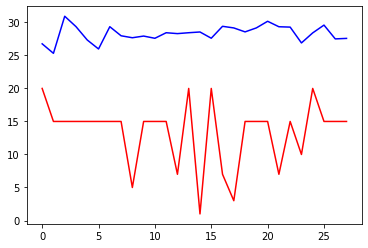

In [77]:
plt.plot(U/12,c="red")
plt.plot(pred/12,c="blue")

In [78]:
U.shape

(28, 1)

In [79]:
pred.shape

(28, 1)

In [80]:
U

,Loan_Amount_Term
0,240.0
1,180.0
2,180.0
3,180.0
4,180.0
5,180.0
6,180.0
7,180.0
8,60.0
9,180.0
